# Support Vector Classifiers (SVCs)

Support Vector Machines (SVMs) sind eine sehr flexible und leistungsfähige Klasse an Methoden für Regression und Klassifikation. Im Alltag werden dabei aber oft einige Begriffe vermischt, die wir hier nun Klarstellen wollen.

Wichtig für das Verständnis ist: 
- Margin Classifier
- Support Vector Classifier
- Support Vector Machine

Wir werden diese Konzepte nun schrittweise anschaulich einführen.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d

from scipy import stats
from sklearn.datasets import make_blobs, make_circles
from sklearn.svm import SVC

plt.style.use('ggplot')
sns.set()

In [2]:
sns.set()
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['image.cmap'] = 'Dark2'

## Motivation

Wir erzeugen uns zunächst mit der `make\_blobs`-Funktion in scikit-learn ein paar Demo-Daten, die zu zwei klar trennbaren Klassen gehören:

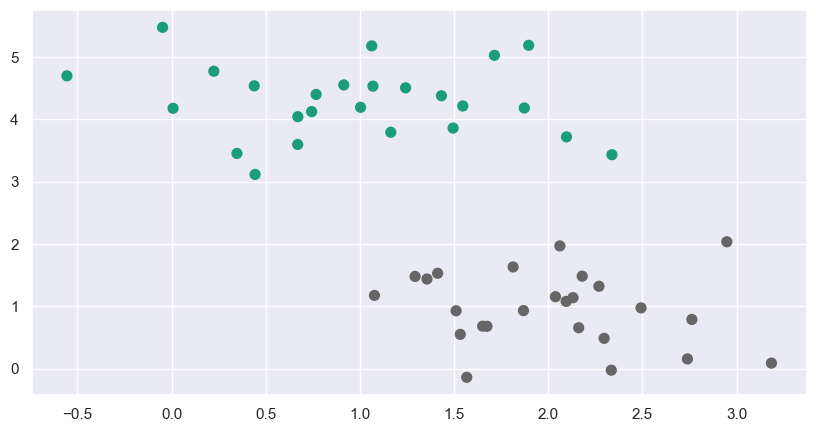

In [3]:
X, y = make_blobs(n_samples = 50, centers = 2, random_state = 0, cluster_std = 0.6)
plt.scatter(X[:, 0], X[:, 1], c = y, s = 50);

Um diese Daten mit einem linearen Klassifikator zu trennen, versuchen wir eine Gerade (in 2D) zwischen diese Punkte zu legen. Allerdings wissen wir bereits, dass es unendlich viele solche Geraden gibt. 

Sehen wir uns beispielhaft 3 an:

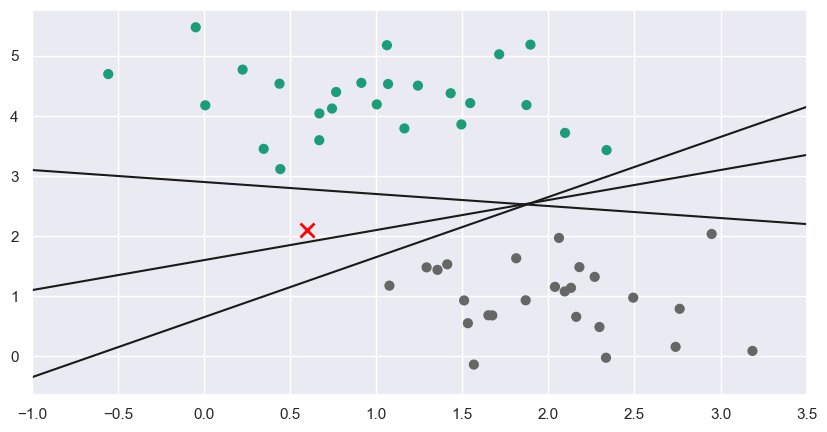

In [4]:
xfit = np.linspace(-1, 3.5)

plt.scatter(X[:, 0], X[:, 1], c = y, s = 40)
plt.plot([0.6], [2.1], 'x', color = 'red', markeredgewidth = 2, markersize = 10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')

plt.xlim(-1, 3.5);

Wir sehen, diese drei Geraden trennen die Punkte perfekt. Je nachdem welche Gerade wir nun wählen, wird der unbekannte Punkte (dargestellt durch das rote X) entweder zur grünen oder zur schwarzen Klasse gehören.

Mathematisch gesehen stellt eine Gerade im 2D eine **Hyperebene** dar. Allgemein ist eine Hyperebene ein lineares Objekt, das eine Dimension kleiner ist als der Raum, in dem sie eingebettet ist (also eine Gerade in 2D, eine Ebene in 3D usw.).

Wir werden uns nun ansehen, wie man eine optimale Hyperebene findet. Die Methode dazu hat Vladimir Vapnik 1982 veröffentlicht.

## Margin Classifier

Der nächste Schritt zu unseren SVMs ist, das Konzept der Geraden (die ja per Definition eine Breite von Null hat) zu erweitern und statt dessen einen Bereich (*Margin*) zu definieren, der zwischen den Klassen trennt. Diesen Bereich dehnt man bis so weit aus, bis der erste Punkt berührt wird. 

Der Support Vector Classifiers wählt dann die Gerade aus, die den maximalen Margin hat (und somit den größten trennenden Abstand zwischen den Punkten):

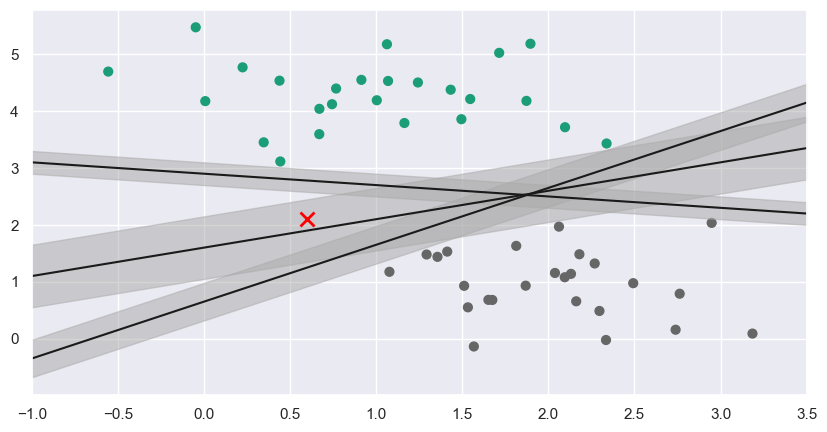

In [5]:
xfit = np.linspace(-1, 3.5)

plt.scatter(X[:, 0], X[:, 1], c = y, s = 40)
plt.plot([0.6], [2.1], 'x', color = 'red', markeredgewidth = 2, markersize = 10)

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor = 'none', color = '#AAAAAA', alpha = 0.5)

plt.xlim(-1, 3.5);

Um eine optimale Hyperebene zu finden benötigt man also nur einen sehr kleinen Teil der Trainingsdaten, die **Supportvektoren**. 

**Anmerkung:** Jeder Datenpunkt ist ein Vektor in unserem d-dimensionalen Raum.

## Support Vector Classifier

Sehen wir uns das gleich mal an einem Beispiel an, bevor wir uns tiefer in die Konzepte der *Kernels* und *Soft-Margins* begeben. 

Wir versuchen nun bei diesen Daten einen Support Vector Classifier zu trainieren. Standardmässig muss man dafür zwei Parameter setzen (mehr dazu später), nämlich die Art des Kernels (wir wählen "linear") und den Parameter $c$ (wir wählen eine sehr große Zahl):

In [6]:
model = SVC(kernel = 'linear', C = 1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Wir verwenden die folgende Funktion für eine bessere Visualisierung der Decision Boundaries und der Supportvektoren:

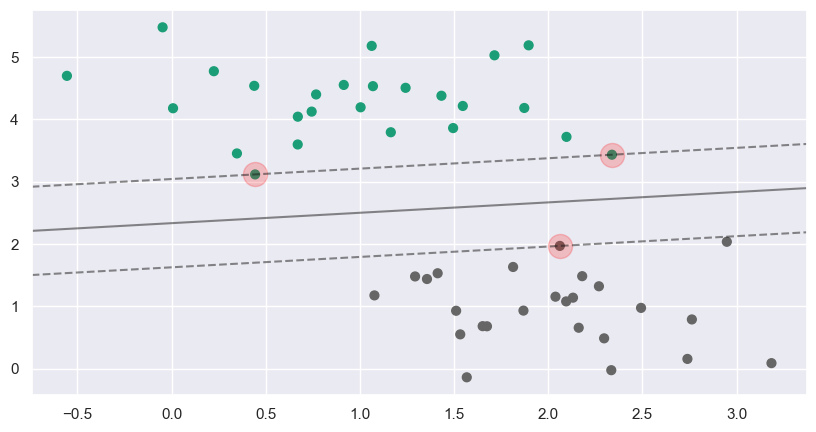

In [7]:
def plot_svc_decision_function(model, ax = None, plot_support = True):
    if ax is None:
        ax = plt.gca()
        
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    ax.contour(X, Y, P, colors = 'k', levels = [-1, 0, 1], alpha = 0.5, linestyles=['--', '-', '--'])
    
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s = 300, lw = 1, facecolors = 'red', alpha = 0.2);
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

plt.scatter(X[:, 0], X[:, 1], c = y, s = 40)
plot_svc_decision_function(model);

Hier sehen wir die Trennline mit dem **maximalen** Margin zwischen den beiden Klassen. Die rot eingezeichneten Punkte sind die Supportvektoren. 

In _scikit-learn_ können wir uns diese leicht mit dem *support\_vector\_* Attribut ausgeben lassen:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Wir sehen hier sehr gut das von Vapnik gefundene Prinzip: Nur ein kleiner Teil der Daten sind nötig, um die optimale Hyperebene zu finden. 

Technisch gesehen liegt das daran, dass alle anderen Datenpunkte nicht zu der Loss-Funktion beitragen, die hier minimiert werden muss. 

Sehen wir uns das etwas näher an: 

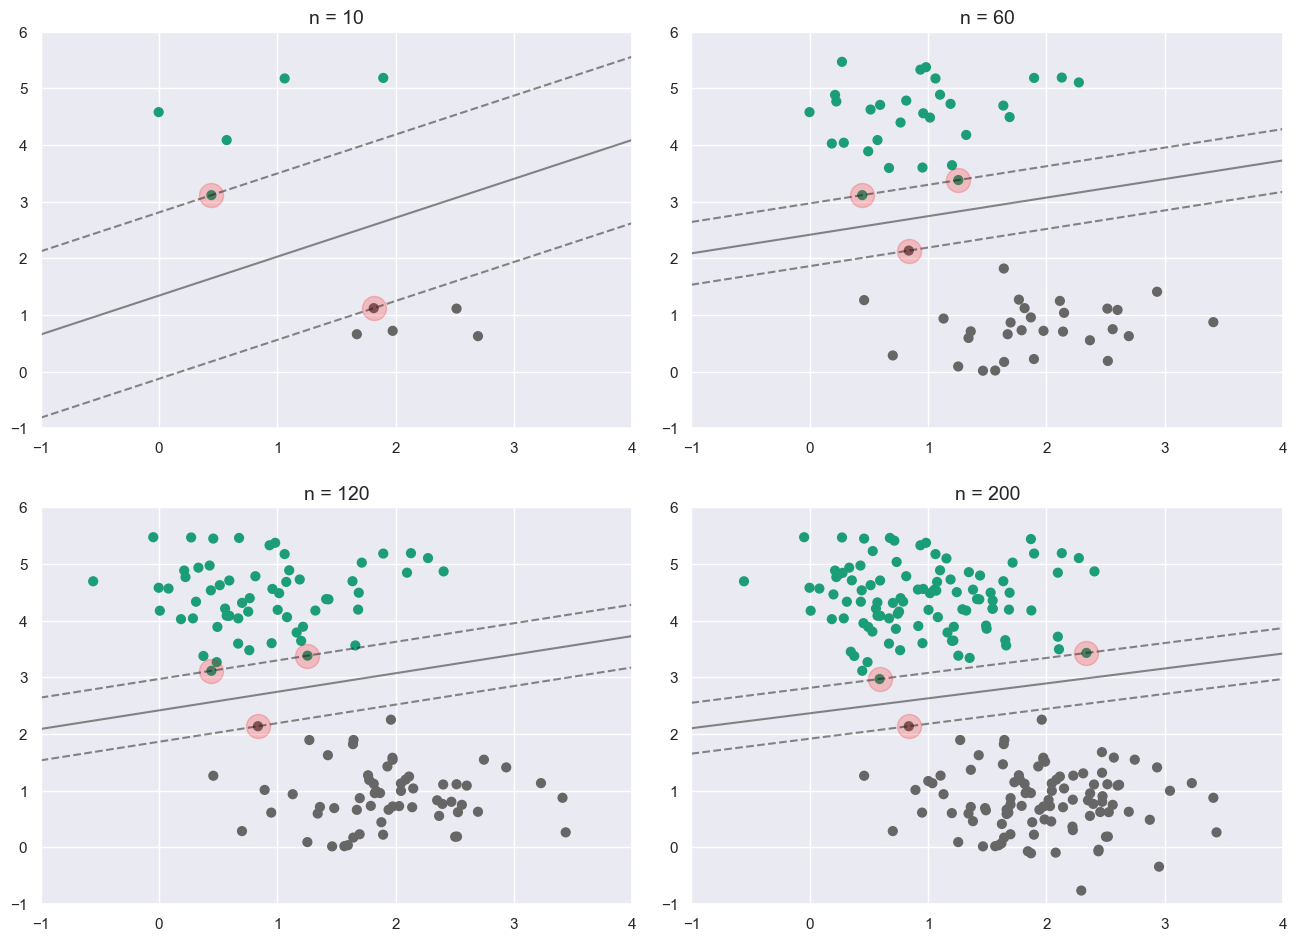

In [9]:
fig, ax = plt.subplots(2, 2, figsize = (14, 8))
fig.subplots_adjust(top = 1.2, left = 0.0625, right = 0.95, wspace = 0.1)

for axi, n in zip(ax.reshape(-1), [10, 60, 120, 200]):
    X, y = make_blobs(n_samples = 200, centers = 2, random_state = 0, cluster_std = 0.60)
    X = X[:n]
    y = y[:n]
    model = SVC(kernel = 'linear', C = 1E10).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c = y, s = 40)
    axi.set_xlim(-1, 4)
    axi.set_ylim(-1, 6)
    plot_svc_decision_function(model, axi)
    axi.set_title(f'n = {n}', size = 14)

Wenn wir den Fall für 60 und 120 Punkte vergleichen, dann sieht man sehr gut, wie wenig das Verhalten der Punkte, die weit von den Supportvektoren entfernt sind, das Klassifikationsverhalten beeinflussen. Das ist eine der Stärken der Support Vector Classifiers!

## Soft Margins

Für Datensätze, bei denen die Klassen so schön getrennt sind, funktioniert die Methode also sehr gut. Was aber, wenn wir überlappende Klassen haben?

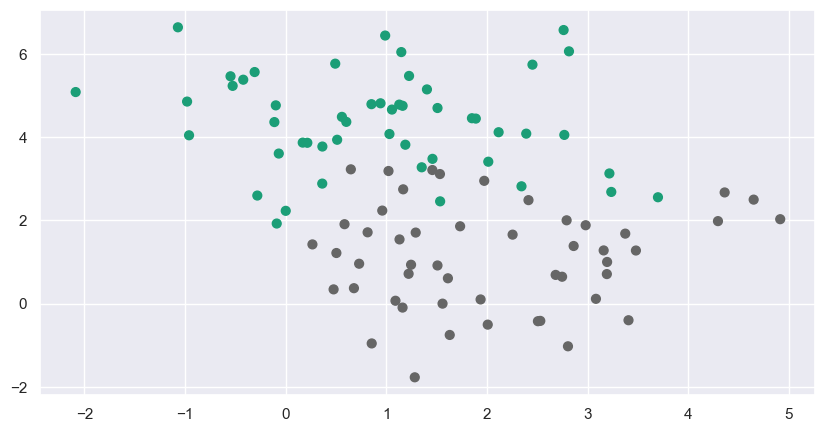

In [10]:
X, y = make_blobs(n_samples=100, centers = 2, random_state = 0, cluster_std = 1.2)
plt.scatter(X[:, 0], X[:, 1], c = y, s = 40);

So, wo ziehen wir nun unsere Gerade. Im Allgemeinen sind Klassifikatoren mit linearen Entscheidungsgrenzen sehr anfällig auf Ausreisser (wie auch schon bei der linearen Regression). Wir müssen daher eine Methode finden, welche die Vorzüge der Supportvektoren beinhaltet.

Wir lösen das Problem, indem wir einige Fehlklassifikationen in Kauf nehmen. Die Trennung der Klassen ziehen wir zwischen den Punkten, die zu ihren Klassen am besten ausgerichtet (zentriert) sind. Somit weichen wir den Bereich für die Punkte auf (*soften the margin*). Einige Punkte dürfen dadurch in dem Trennbereich der Klassen liegen. 

Wie streng diese Trennung ist, wird mit einem Hyperparamter (also einem Parameter, den wir dem Modell mitgeben und der nicht von dem Modell gelernt wird) festgelegt. Man spricht auch von der Stärke der Regularisierung und der Parameter nennt sich _c_. Der Parameter muss positiv sein und die Stärke der Regularisierung ist indirekt proportional zum Wert von _c_.

Ist _c_ sehr groß (wie oben), dann ist die Trennung sehr streng und kein Punkt darf im Margin liegen. Für kleinere _c_ haben wir einen *soft margin*, der eine gewisse Anzahl an Fehlklassifikationen erlaubt. 

Sehen wir uns das wieder für verschiedene Werte von _c_ an:

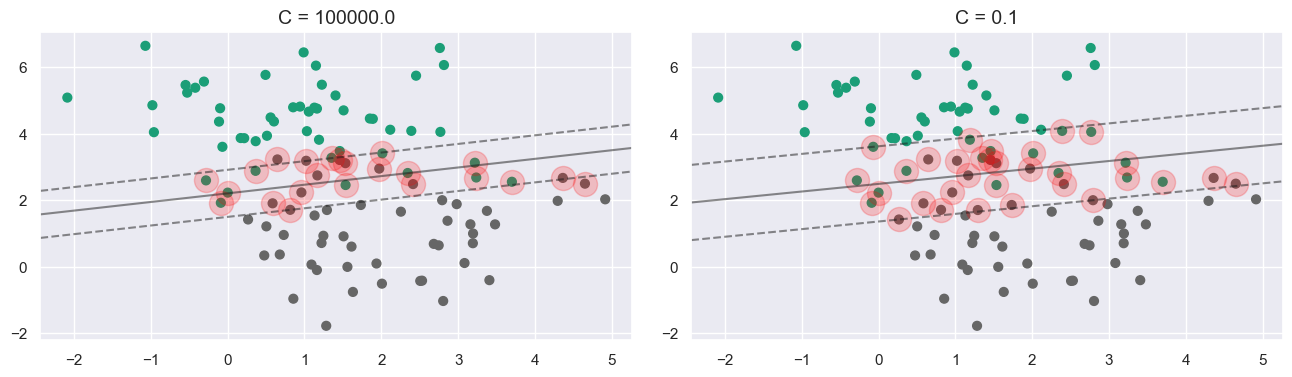

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
fig.subplots_adjust(left = 0.0625, right = 0.95, wspace = 0.1)

for axi, C in zip(ax, [1E5, 0.1]):
    model = SVC(kernel = 'linear', C = C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c = y, s = 40)
    plot_svc_decision_function(model, axi)
    axi.set_title('C = {0:.1f}'.format(C), size = 14)

Die Wahl von _c_ hat einen direkten Einfluss auf Bias und Varianz. Ein hoher Wert wählt einn Bereich, der sehr stark auf die Trainingsdaten optimiert und dadurch einen geringen Bias hat. Bei neuen Daten kann das Ergebnis dann entsprechend schlecht sein (hohe Varianz). Bei einem kleinen Wert ist es genau umgekehrt. 

Die optimale Wahl von _c_ hängt sehr stark von den Daten ab und es sollten auf jeden Fall Verfahren wie Cross-Validation verwendet werden.